In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [31]:
'''
Searching for chargers in SF
'''
deep_reload(src)

lon=-122.42732940666399
lat=37.77232101767774

result=src.requests.TomTom_Location_Search(lon,lat)

https://api.tomtom.com/search/2/nearbySearch/.json?key=ercfF032eCm1qy8QKpS37UIEeGoWkb8Z&lon=-122.42732940666399&lat=37.77232101767774&radius=5000&limit=100&categorySet=7309


In [32]:
result['results'][0]

{'type': 'POI',
 'id': 'YjKMl-AndGNr4WPDzC1I1w',
 'score': 99.6276855469,
 'dist': 372.307313,
 'info': 'search:ev:5551f3a1-4f18-41dd-8097-41c7fd129015',
 'poi': {'name': '431407 : Avalon Hayes Valley',
  'categorySet': [{'id': 7309}],
  'url': 'www.blinkcharging.com',
  'categories': ['electric vehicle station'],
  'classifications': [{'code': 'ELECTRIC_VEHICLE_STATION',
    'names': [{'nameLocale': 'en-US', 'name': 'electric vehicle station'}]}]},
 'address': {'streetNumber': '325',
  'streetName': 'Octavia Street',
  'municipalitySubdivision': 'Hayes Valley',
  'municipality': 'San Francisco',
  'countrySecondarySubdivision': 'San Francisco',
  'countrySubdivision': 'CA',
  'countrySubdivisionName': 'California',
  'countrySubdivisionCode': 'CA',
  'postalCode': '94102',
  'countryCode': 'US',
  'country': 'United States',
  'countryCodeISO3': 'USA',
  'freeformAddress': '325 Octavia Street, SF, CA 94102',
  'localName': 'SF'},
 'position': {'lat': 37.774969, 'lon': -122.424738},
 '

In [33]:
'''
Charger status
'''
deep_reload(src)

id=result['results'][0]['dataSources']['chargingAvailability']['id']

charger_availability=src.requests.TomTom_EVSE_Information(id)

https://api.tomtom.com/search/2/chargingAvailability.json?key=ercfF032eCm1qy8QKpS37UIEeGoWkb8Z&chargingAvailability=5551f3a1-4f18-41dd-8097-41c7fd129015


In [34]:
charger_availability

{'connectors': [{'type': 'IEC62196Type1',
   'total': 4,
   'availability': {'current': {'available': 2,
     'occupied': 2,
     'reserved': 0,
     'unknown': 0,
     'outOfService': 0},
    'perPowerLevel': [{'powerKW': 6.0,
      'available': 2,
      'occupied': 2,
      'reserved': 0,
      'unknown': 0,
      'outOfService': 0}]}}],
 'chargingAvailability': '5551f3a1-4f18-41dd-8097-41c7fd129015'}

In [44]:
'''
Charger status for all identified chargers
'''
deep_reload(src)

charger_ids=[]

for res in result['results']:
    if 'dataSources' in res.keys():
        charger_ids.append(res['dataSources']['chargingAvailability']['id'])

# print(charger_ids)
charger_availability_results=src.requests.TomTom_EVSE_Information(charger_ids)

 Progress [------------------->] (55/55) 101%, 4.03 it/s, 13.90 seconds elapsed, -0.25 seconds remaining         



In [50]:
'''
Making plotable results
'''

#Adding LonLat

for key,val in charger_availability_results.items():

    for res in result['results']:
        if 'dataSources' in res.keys():
            if res['dataSources']['chargingAvailability']['id']==key:
                val['position']=res['position']
                val['id']=res['id']

In [64]:
chg_info={}
chg_info['ids']=[v['id'] for k,v in charger_availability_results.items()]
chg_info['lon']=[v['position']['lon'] for k,v in charger_availability_results.items()]
chg_info['lat']=[v['position']['lat'] for k,v in charger_availability_results.items()]
chg_info['tot']=[v['connectors'][0]['total'] for k,v in charger_availability_results.items()]
chg_info['occ']=[v['connectors'][0]['availability']['perPowerLevel'][0]['occupied'] for k,v in charger_availability_results.items()]
chg_info['oos']=[v['connectors'][0]['availability']['perPowerLevel'][0]['outOfService'] for k,v in charger_availability_results.items()]
chg_info['pow']=[v['connectors'][0]['availability']['perPowerLevel'][0]['powerKW'] for k,v in charger_availability_results.items()]

In [68]:
df_chg=pd.DataFrame.from_dict(chg_info)
gdf_chg = gpd.GeoDataFrame(
    df_chg, geometry=gpd.points_from_xy(df_chg.lon, df_chg.lat), crs="EPSG:4326"
)

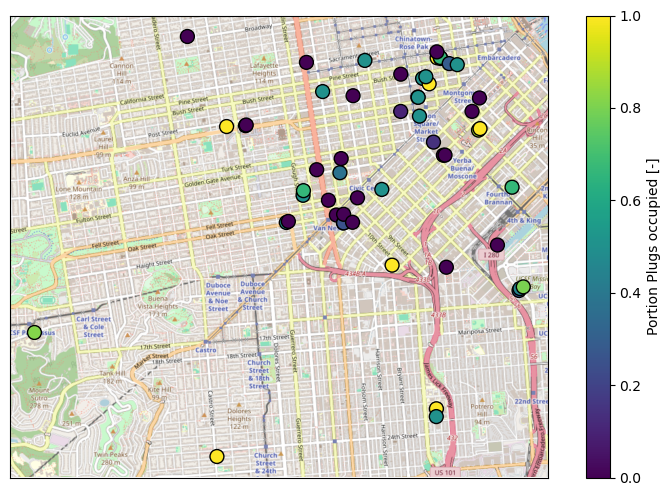

In [90]:
import contextily as cx
deep_reload(src)

fig,ax=plt.subplots(1,1,figsize=(10,6))

cmap=src.figures.ReturnColorMap('viridis')

gdf_chg=gdf_chg.to_crs(3857)

gdf_chg['occ_rat']=gdf_chg['occ']/gdf_chg['tot']

gdf_chg.plot(ax=ax,column='occ_rat',ec='k',markersize=100)
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik,attribution='')

colorbar_kwargs={'label':'Portion Plugs occupied [-]'}
values=gdf_chg['occ_rat']
vmin=min(values)
vmax=max(values)
sm=plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm,ax=ax,**colorbar_kwargs)

ax.set(**{
    'xticks':[],
    'yticks':[],
})

fig.savefig('portion_occupied.png',bbox_inches='tight',dpi=300)

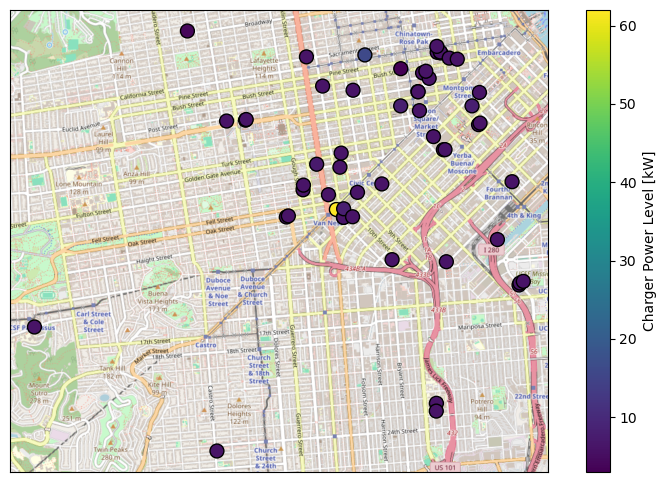

In [89]:
import contextily as cx
deep_reload(src)

fig,ax=plt.subplots(1,1,figsize=(10,6))

cmap=src.figures.ReturnColorMap('viridis')

gdf_chg=gdf_chg.to_crs(3857)

gdf_chg['occ_rat']=gdf_chg['occ']/gdf_chg['tot']

gdf_chg.plot(ax=ax,column='pow',ec='k',markersize=100)
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik,attribution='')

colorbar_kwargs={'label':'Charger Power Level [kW]'}
values=gdf_chg['pow']
vmin=min(values)
vmax=max(values)
sm=plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm,ax=ax,**colorbar_kwargs)

ax.set(**{
    'xticks':[],
    'yticks':[],
})

fig.savefig('power_level.png',bbox_inches='tight',dpi=300)

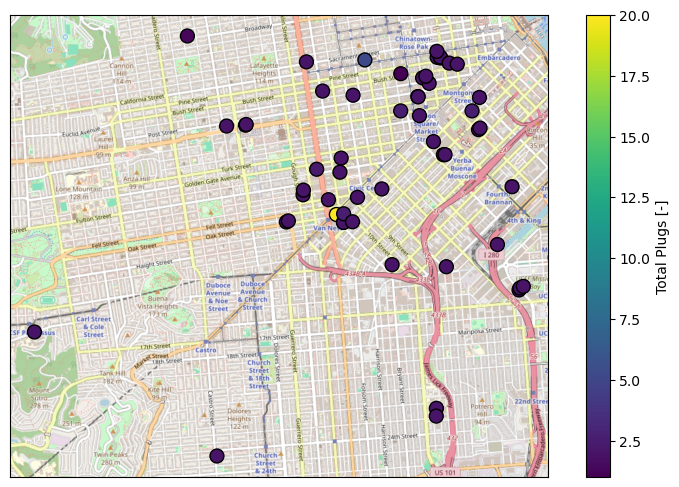

In [88]:
import contextily as cx
deep_reload(src)

fig,ax=plt.subplots(1,1,figsize=(10,6))

cmap=src.figures.ReturnColorMap('viridis')

gdf_chg=gdf_chg.to_crs(3857)

gdf_chg['occ_rat']=gdf_chg['tot']/gdf_chg['tot']

gdf_chg.plot(ax=ax,column='pow',ec='k',markersize=100)
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik,attribution='')

colorbar_kwargs={'label':'Total Plugs [-]'}
values=gdf_chg['tot']
vmin=min(values)
vmax=max(values)
sm=plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm,ax=ax,**colorbar_kwargs)

ax.set(**{
    'xticks':[],
    'yticks':[],
})

fig.savefig('total_plugs.png',bbox_inches='tight',dpi=300)

In [91]:
24*60/5

288.0

In [92]:
TMAS_Locations=gpd.read_file(
		'Data/Travel_Monitoring_Analysis_System_Stations_CA.shp').to_crs(4326)

In [94]:
TMAS_Locations

,OBJECTID,Station_Id,lat1,long1,FC,state,geometry
0,735,011040,41.013556,-124.107946,3R,CA,POINT (-124.10795 41.01356)
1,736,011060,40.886269,-124.079669,2U,CA,POINT (-124.07967 40.88627)
2,737,011070,40.818163,-124.097615,2U,CA,POINT (-124.09762 40.81816)
3,738,011090,40.901643,-123.610052,3R,CA,POINT (-123.61005 40.90164)
4,739,011100,40.637084,-124.211723,3R,CA,POINT (-124.21172 40.63708)
...,...,...,...,...,...,...,...
265,1000,128080,33.857971,-117.782216,2U,CA,POINT (-117.78222 33.85797)
266,1001,129010,33.453075,-117.644281,1U,CA,POINT (-117.64428 33.45308)
267,1002,129050,33.740490,-117.833308,1U,CA,POINT (-117.83331 33.74049)
268,1003,129130,33.850898,-117.814391,2U,CA,POINT (-117.81439 33.85090)


[(-120.0, -118.5), (34.5, 37.0)]

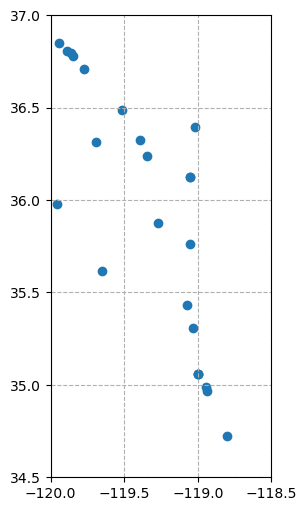

In [96]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
TMAS_Locations.plot(ax=ax)
ax.grid(ls='--')
ax.set(**{'xlim':[-120,-118.5],'ylim':[34.5,37]})

In [121]:
TMAS_Locations_sel=TMAS_Locations[(
    (TMAS_Locations.long1>=-120)&
    (TMAS_Locations.long1<=-118.5)&
    (TMAS_Locations.lat1>=34.5)&
    (TMAS_Locations.lat1<=37)
)]

lon=TMAS_Locations_sel.long1.to_numpy()
lat=TMAS_Locations_sel.lat1.to_numpy()

In [129]:
'''
Searching for chargers in Cental Valley
'''
deep_reload(src)

radius=50000
limit=10

location_reslts=[None]*len(lon)

for idx in range(len(lon)):
    location_reslts[idx]=src.requests.TomTom_Location_Search(
        lon[idx],lat[idx],radius=radius,limit=limit)

In [130]:
results=[]

for loc_res in location_reslts:
    results.extend(loc_res['results'])

In [131]:
results[0]

{'type': 'POI',
 'id': 'YM3WbqIuU3_swEBLnBLY2w',
 'score': 99.5873031616,
 'dist': 412.691719,
 'info': 'search:ev:75392c57-984a-4cc1-8ee8-d5845ffdf042',
 'poi': {'name': 'EVCS',
  'phone': '+31 88 775 5444',
  'categorySet': [{'id': 7309}],
  'categories': ['electric vehicle station'],
  'classifications': [{'code': 'ELECTRIC_VEHICLE_STATION',
    'names': [{'nameLocale': 'en-US', 'name': 'electric vehicle station'}]}]},
 'address': {'streetNumber': '8700',
  'streetName': 'Spectrum Park Way',
  'municipality': 'Bakersfield',
  'countrySecondarySubdivision': 'Kern',
  'countrySubdivision': 'CA',
  'countrySubdivisionName': 'California',
  'countrySubdivisionCode': 'CA',
  'postalCode': '93308',
  'countryCode': 'US',
  'country': 'United States',
  'countryCodeISO3': 'USA',
  'freeformAddress': '8700 Spectrum Park Way, Bakersfield, CA 93308',
  'localName': 'Bakersfield'},
 'position': {'lat': 35.438283, 'lon': -119.075347},
 'viewport': {'topLeftPoint': {'lat': 35.43918, 'lon': -119.

In [132]:
'''
Charger status for all identified chargers
'''
deep_reload(src)

charger_ids=[]

for res in results:
    if 'dataSources' in res.keys():
        charger_ids.append(res['dataSources']['chargingAvailability']['id'])
        
charger_ids=np.unique(charger_ids)
charger_ids.shape

(79,)

In [133]:
# print(charger_ids)
charger_availability_results=src.requests.TomTom_EVSE_Information(charger_ids)

 Progress [------------------->] (79/79) 101%, 5.22 it/s, 15.33 seconds elapsed, -0.19 seconds remaining         



In [134]:
'''
Making plotable results
'''

#Adding LonLat

for key,val in charger_availability_results.items():

    for res in results:
        if 'dataSources' in res.keys():
            if res['dataSources']['chargingAvailability']['id']==key:
                val['position']=res['position']
                val['id']=res['id']

In [142]:
chg_info={'ids':[],'lon':[],'lat':[],'tot':[],'occ':[],'oos':[],'pow':[]}

for k,v in charger_availability_results.items():
    if v['connectors']:
        chg_info['ids'].append(v['id'])
        chg_info['lon'].append(v['position']['lon'])
        chg_info['lat'].append(v['position']['lat'])
        chg_info['tot'].append(v['connectors'][0]['total'])
        chg_info['occ'].append(
            v['connectors'][0]['availability']['perPowerLevel'][0]['occupied'])
        chg_info['oos'].append(
            v['connectors'][0]['availability']['perPowerLevel'][0]['outOfService'])
        chg_info['pow'].append(
            v['connectors'][0]['availability']['perPowerLevel'][0]['powerKW'])

In [143]:
df_chg=pd.DataFrame.from_dict(chg_info)
gdf_chg = gpd.GeoDataFrame(
    df_chg, geometry=gpd.points_from_xy(df_chg.lon, df_chg.lat), crs="EPSG:4326"
)

<Axes: >

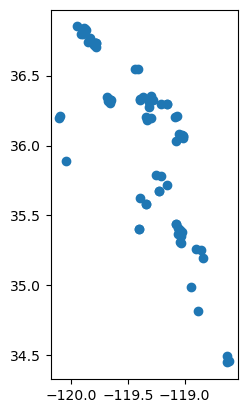

In [144]:
gdf_chg.plot()

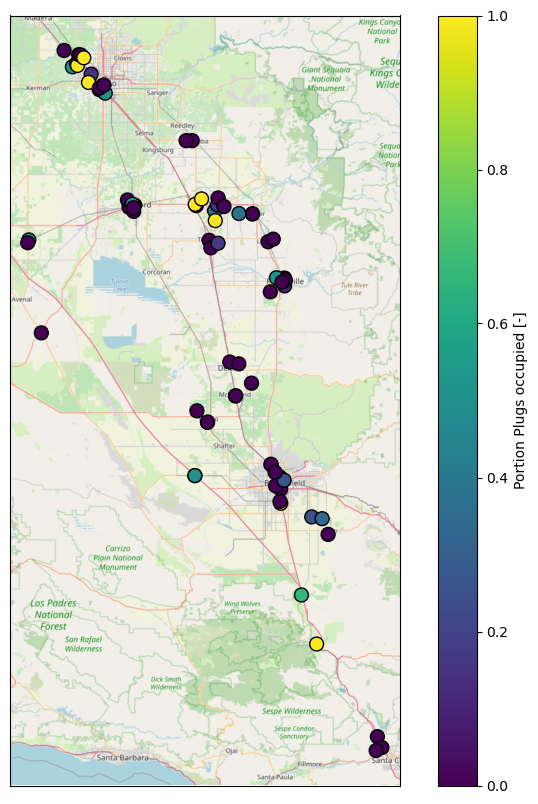

In [147]:
import contextily as cx
deep_reload(src)

fig,ax=plt.subplots(1,1,figsize=(10,10))

cmap=src.figures.ReturnColorMap('viridis')

gdf_chg=gdf_chg.to_crs(3857)

gdf_chg['occ_rat']=gdf_chg['occ']/gdf_chg['tot']

gdf_chg.plot(ax=ax,column='occ_rat',ec='k',markersize=100)
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik,attribution='')

colorbar_kwargs={'label':'Portion Plugs occupied [-]'}
values=gdf_chg['occ_rat']
vmin=min(values)
vmax=max(values)
sm=plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm,ax=ax,**colorbar_kwargs)

ax.set(**{
    'xticks':[],
    'yticks':[],
})

fig.savefig('portion_occupied_cv.png',bbox_inches='tight',dpi=300)

In [101]:
def ExtractInfo(res):
    info={}
    info['ids']=[v['id'] for k,v in res.items()]
    info['lon']=[v['position']['lon'] for k,v in res.items()]
    info['lat']=[v['position']['lat'] for k,v in res.items()]
    info['tot']=[v['connectors'][0]['total'] for k,v in res.items()]
    info['occ']=[v['connectors'][0]['availability']['perPowerLevel'][0]['occupied'] \
                     for k,v in res.items()]
    info['oos']=[v['connectors'][0]['availability']['perPowerLevel'][0]['outOfService'] \
                     for k,v in res.items()]
    info['pow']=[v['connectors'][0]['availability']['perPowerLevel'][0]['powerKW'] \
                     for k,v in res.items()]
    return info

In [ ]:
plt_info=[None]*len(lon)
for idx,loc_req in location_reslts:
    plt_info[idx]=ExtractInfo(location_reslts)